In [16]:
#import some python libraries
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
import timeit
from IPython.display import Image; Image("EBTeqn.png")

label_size = 15 #make size of axis tick labels larger
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

#define linear fitting function
def linearfit(x, m, b):  # define variables in each function
    return m * x + b 

#Define some constants
s = 1.62e-15 #cm^2 (.162 #nm^2) cross sectional area of N2 adsorbate
Na = 6.0221409e23 #Avogadros number
Vm = 22390 #cm^3/mol = molar volume of N2
mm = 28.0134 #g/mol molecular mass of N2

#input sample masses in grams
samplemass = {'b56': 0.035, 'b56r': 0.035, 'b75': 0.0371, 'b75r': 0.0371,
               'b8': 0.1, 'graphite': 0.052, 't1150': 0.034}


#find all the files in the designated folder
##############################################################################
filepath = 'C:\\Users\\a6q\\Desktop\\boron-carbon\\BET spray deposited boron carbon\\boron carbon BET sd\\formatted/*'
##############################################################################
folder = glob.glob(filepath)
print('Imported ' + format(len(folder)) + ' files:') #print number of files found in folder
print("\n".join(list(folder))) #print name of each file imported

Imported 7 files:
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\b56.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\b56r.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\b75.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\b75r.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\b8.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\graphite.csv
C:\Users\a6q\Desktop\boron-carbon\BET spray deposited boron carbon\boron carbon BET sd\formatted\t1150.csv


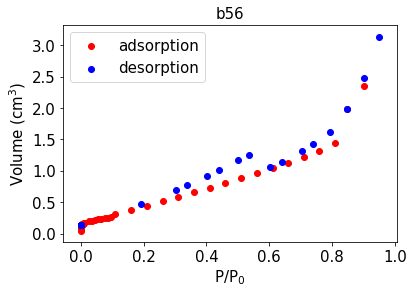

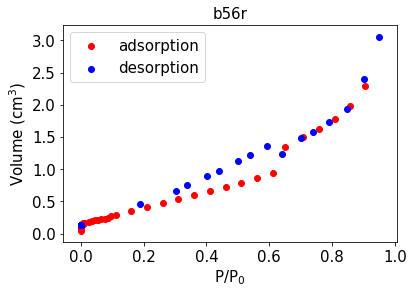

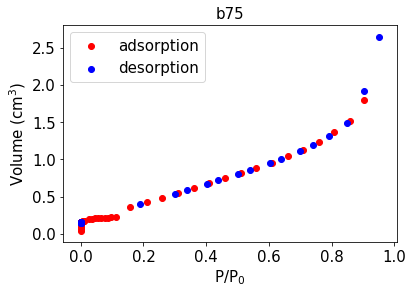

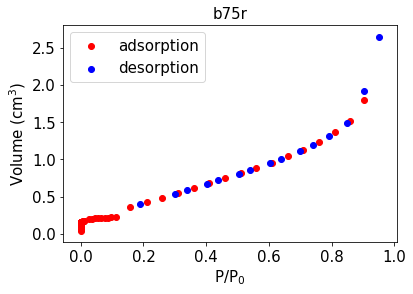

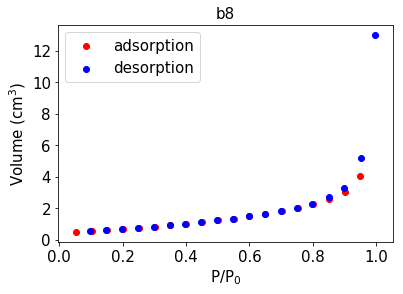

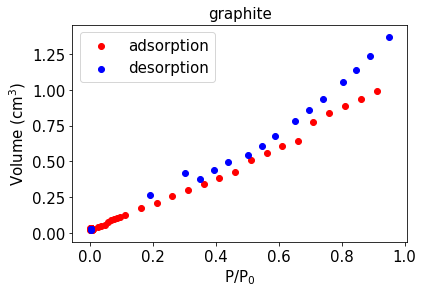

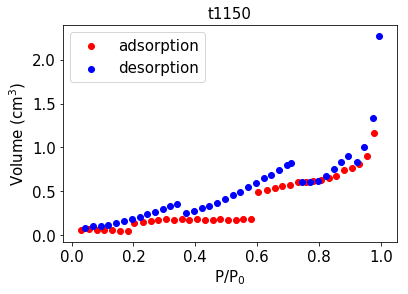

In [17]:
#plot raw BET data

samplenames = [] #create empty list of sample names
for i in range(len(folder)): #loop over each file in folder
    data = pd.read_csv(folder[i]) #read in data from each file
    samplename = os.path.basename(folder[i]).split('.')[0] #split filename at "." to remove .csv     
    samplenames.append(samplename) #make list of sample names
    p = np.array(data['p']); v = np.array(data['v']) #make arrays out of p and v variables
    
    pad = []; pdes = []; vad = []; vdes = []
    for i in range(len(p)-1): #separate adsorption and desorption regions in plin and vlin
        if p[i+1] > p[i]:
            pad.append(p[i]); vad.append(v[i])
        if p[i+1] < p[i]:
            pdes.append(p[i]); vdes.append(v[i])
        else:
            pass
    
    plt.scatter(pad, vad, label='adsorption', color='r') #scatter plot of raw adsorption points
    plt.scatter(pdes, vdes, label='desorption', color='b') #scatter plot of raw desorption points
    plt.xlabel('P/P$_0$', fontsize=15); plt.ylabel('Volume (cm$^3$)', fontsize = 15) #set axis labels
    plt.title(samplename, fontsize=15) #print title of each plot
    plt.legend(fontsize=15); plt.show() #show plot legend and print plot

![title](BETeqn.png)

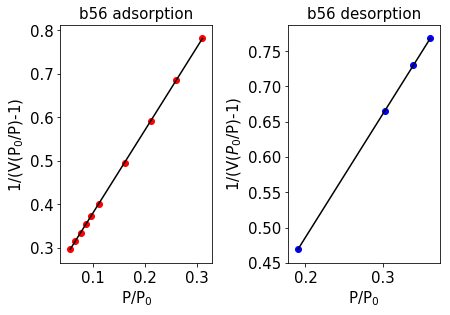

b56 spec. surf. area from adsorption = 72.56 m^2/g; r^2 = 0.987
b56 spec. surf. area from desorption = 76.98 m^2/g; r^2 = 0.77


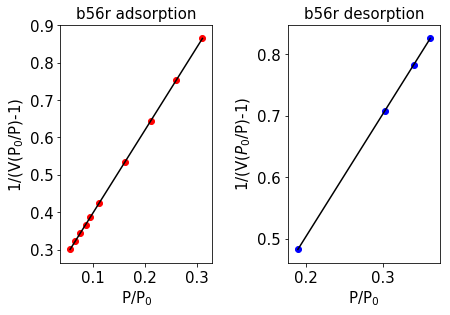

b56r spec. surf. area from adsorption = 61.3 m^2/g; r^2 = 0.994
b56r spec. surf. area from desorption = 65.58 m^2/g; r^2 = 0.71


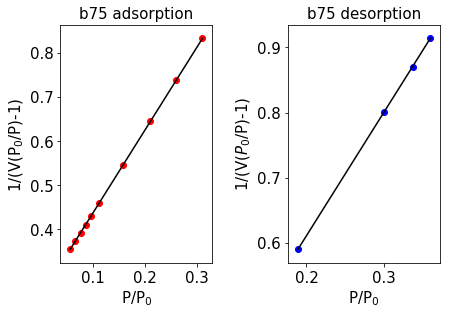

b75 spec. surf. area from adsorption = 72.25 m^2/g; r^2 = 0.92
b75 spec. surf. area from desorption = 71.11 m^2/g; r^2 = 1.0


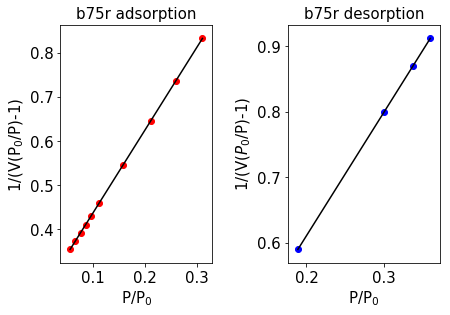

b75r spec. surf. area from adsorption = 72.25 m^2/g; r^2 = 0.921
b75r spec. surf. area from desorption = 71.21 m^2/g; r^2 = 1.0


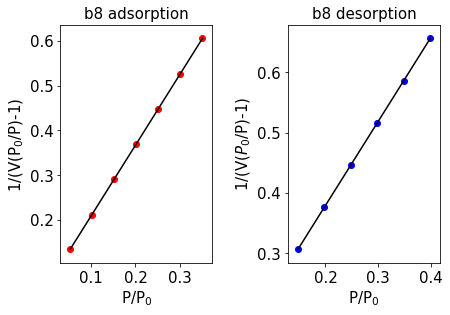

b8 spec. surf. area from adsorption = 28.49 m^2/g; r^2 = 0.992
b8 spec. surf. area from desorption = 33.51 m^2/g; r^2 = 0.997


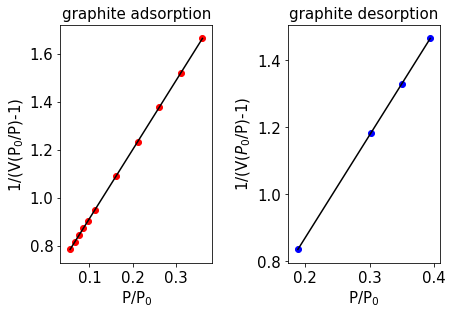

graphite spec. surf. area from adsorption = 37.24 m^2/g; r^2 = 0.992
graphite spec. surf. area from desorption = 29.74 m^2/g; r^2 = 0.863


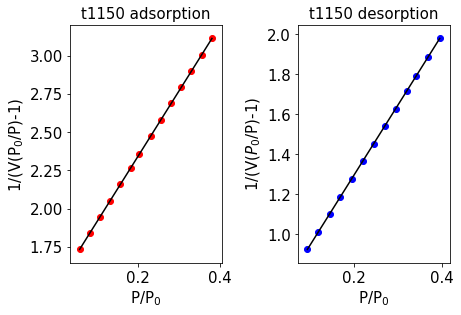

t1150 spec. surf. area from adsorption = 46.71 m^2/g; r^2 = 0.225
t1150 spec. surf. area from desorption = 44.04 m^2/g; r^2 = 0.67


In [26]:
#loop over each file in the folder
specSA_ad = [] #empty list of specific surface areas
specSA_des = [] #empty list of specific surface areas

for i in range(len(folder)): #loop over each file in folder
    data = pd.read_csv(folder[i]) #read in data from each file
    samplename = os.path.basename(folder[i]).split('.')[0] #split filename at "." to remove .csv
    
    #find linear regime for fitting
    #########################################################################
    p0 = 0.05 #first pressure in linear regime
    p1 = 0.4 #last pressure in linear regime
    #########################################################################
    prange = data['p'].between(p0, p1) #select range of pressures between p0 and p1
    
    plin = []; vlin=[] #initialize pressure_linear and volume_linear arrays
    for i in range(len(prange)):
        if prange[i] == True:
            plin.append(data['p'][i]) #create plin and vlin from values between p0 and p1
            vlin.append(data['v'][i])
        else:
            pass
    
    plinad = []; plindes = []; vlinad = []; vlindes = []
    for i in range(len(plin)-1): #separate adsorption and desorption regions in plin and vlin
        if plin[i+1] > plin[i]:
            plinad.append(plin[i]); vlinad.append(vlin[i])
        if plin[i+1] < plin[i]:
            plindes.append(plin[i]); vlindes.append(vlin[i])
        else:
            pass
        
    plindes = np.array(plindes); plinad = np.array(plinad) #change lists into arrays for computations
    vlinad = np.array(vlinad); vlindes = np.array(vlindes)
    
    #surf. area from ADSORPTION ##################################################################################
    yad = 1 / (vlinad * ((1/plinad) - 1)) #create y value for BET plot: y = 1/(v*(p0/p)-1)
    popt, pcov = curve_fit(linearfit, plinad, yad) #find fit parameters
    BETfit_ad =  linearfit(plinad, *popt) #build fit line
    
    #calculate r^2 value for fit:
    residuals_ad = yad - linearfit(plinad, *popt) #residuals from fit
    r2_ad = 1 - (np.sum(residuals_ad**2) / np.sum((yad-np.mean(yad))**2)) #r^2 value
    
    #perform calculations for analyzing BET data
    m = popt[0]; b = popt[1] #get slope and y-intercent of each linear fit
    vm = 1 / (m - b) #calculate monolayer capacity
    c = 1 + (m / b) #calculate BET constant    
    
    SAtotal_ad = vm * Na * s / Vm #total surface area in cm^2
    SBET_ad = (SAtotal_ad / samplemass[samplename]) * 1e-4 #specific surface area in m^2/g
    SBET_ad = round(SBET_ad, 2) #round to 2 decimal places
 
    ##create figure for subplots
    plt.subplot(1,2,1); plt.tight_layout(); plt.subplots_adjust(wspace=0.5)
    
    plt.plot(plinad, BETfit_ad, color='k') #plot linear fit
    plt.scatter(plinad, BETfit_ad, label=samplename, color='r') #scatter plot of points
    plt.xlabel('P/P$_0$', fontsize=15); plt.ylabel('1/(V(P$_0$/P)-1)', fontsize = 15) #set axis labels
    plt.title(samplename + ' adsorption', fontsize=15); #show plot legend and print plot
    
    specSA_ad.append(SBET_ad) #collect all specific surface areas

    #surf. area from DESORPTION ######################################################################################
    ydes = 1 / (vlindes * ((1/plindes) - 1)) #create y value for BET plot: y = 1/(v*(p0/p)-1)
    popt, pcov = curve_fit(linearfit, plindes, ydes) #find fit parameters
    BETfit_des =  linearfit(plindes, *popt) #build fit line
    
    #calculate r^2 value for fit:
    residuals_des = ydes - linearfit(plindes, *popt) #residuals from fit
    r2_des = 1 - (np.sum(residuals_des**2) / np.sum((ydes-np.mean(ydes))**2)) #r^2 value
    
    #perform calculations for analyzing BET data
    m = popt[0]; b = popt[1] #get slope and y-intercent of each linear fit
    vm = 1 / (m - b) #calculate monolayer capacity
    c = 1 + (m / b) #calculate BET constant    
    
    SAtotal_des = vm * Na * s / Vm #total surface area in cm^2
    SBET_des = (SAtotal_des / samplemass[samplename]) * 1e-4 #specific surface area in m^2/g
    SBET_des = round(SBET_des, 2) #round to 2 decimal places
    
    plt.subplot(1,2,2)
    plt.plot(plindes, BETfit_des, color='k') #plot linear fit
    plt.scatter(plindes, BETfit_des, label=samplename, color='b') #scatter plot of points
    plt.xlabel('P/P$_0$', fontsize=15); plt.ylabel('1/(V($P_0$/P)-1)', fontsize = 15) #set axis labels
    plt.title(samplename + ' desorption', fontsize=15); plt.show() #show plot legend and print plot
    
    print(samplename +' spec. surf. area from adsorption = '+format(SBET_ad)+' m^2/g; r^2 = '+format(round(r2_ad,3)))
    print(samplename +' spec. surf. area from desorption = '+format(SBET_des)+' m^2/g; r^2 = '+format(round(r2_des,3)))
    specSA_des.append(SBET_des) #collect all specific surface areas

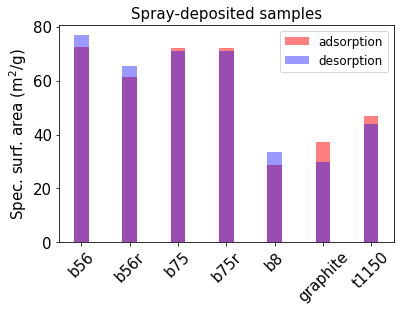

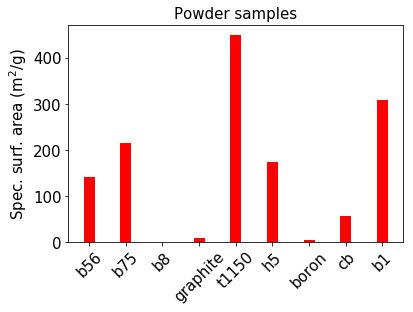

In [20]:
#plot bar graph of spray-deposited specific surface areas and compare to powders

plt.bar(np.arange(len(samplenames)), specSA_ad, width=0.3, color='r', align='center', alpha=.5, label='adsorption')
plt.bar(np.arange(len(samplenames)), specSA_des, width=0.3, color='b', align='center', alpha=.4, label='desorption')
plt.xticks(np.arange(len(samplenames)), samplenames, rotation=45) #set x-value names
plt.ylabel('Spec. surf. area (m$^2$/g)', size=15); plt.title('Spray-deposited samples', fontsize=15)
plt.legend(fontsize=12)
plt.show()


#specific surface areas from BET run on powder samples
powderSSA = {'b56': 142.2224, 'b75': 215.8535, 'b8': 0, 'graphite': 8.2353, 't1150': 449.7432, 
             'h5': 175.0013, 'boron': 4.3505, 'cb': 57.1891, 'b1': 309.233}

plt.bar(np.arange(len(powderSSA)), list(powderSSA.values()), width=0.3, color='r', align='center', alpha=1)
plt.xticks(np.arange(len(powderSSA)), list(powderSSA.keys()), rotation=45) #set x-value names
plt.ylabel('Spec. surf. area (m$^2$/g)', size=15); plt.title('Powder samples', fontsize=15)
plt.show()
